In [56]:
import keras
import json
import pandas as pd
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from keras.utils import plot_model
from keras import metrics
from matplotlib import pyplot as plt
import random
import numpy as np
from keras import backend as K

In [3]:
with open('business.json') as file:
    data = [json.loads(line) for line in file]
with open('photo.json') as file:
    photos = [json.loads(line) for line in file]

In [4]:
df = pd.DataFrame(data)
restaurants = df[df['categories'].str.contains('Restaurants').fillna(False)]
restaurants = restaurants[restaurants['review_count'] >= 50]
in_restaurants = {restaurants['business_id'].iloc[i] : True for i in range(len(restaurants))}

random.seed(0)
random.shuffle(photos)

In [5]:
MAX = 3774 * 2
high = 4.5
low = 2.5
X, y = [], [] 

count = [0, 0]
for photo in photos:
    if len(X) >= MAX:
        break
    name, photo_id = photo['business_id'], photo['photo_id']
    if photo['label'] != 'food' or name not in in_restaurants.keys():
        continue
    rating = restaurants[restaurants['business_id'] == name]['stars'].iloc[0]
    if (rating < high and rating > low) or count[int(rating >= high)] >= MAX/2:
        continue
    count[int(rating >= high)] += 1
    photo_array = imread('photos/' + photo_id + '.jpg')
    resized = resize(photo_array, (128, 128, 3), anti_aliasing = True)
    X.append(resized)
    y.append(float(rating >= high))
    
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

/home/mbper/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
def construct():
    image = Input(shape=(128, 128, 3))

    x1 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(image)
    x2 = MaxPooling2D(pool_size=2)(x1)
    x3 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(x2)
    x4 = MaxPooling2D(pool_size=2)(x3)
    x5 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(x4)
    encoded = MaxPooling2D(pool_size=2)(x5)

    y1 = UpSampling2D(size=2)(encoded)
    y2 = Conv2D(32, 3, strides=1, padding='same', activation = 'relu')(y1)
    y3 = UpSampling2D(size=2)(y2)
    y4 = Conv2D(64, 3, strides=1, padding='same', activation = 'relu')(y3)
    y5 = UpSampling2D(size=2)(y4)
    reconstructed = Conv2D(3, 3, strides=1, padding='same', activation = 'sigmoid')(y5)

    z1 = Conv2D(64, 3, strides=1, padding='same')(encoded)
    z2 = MaxPooling2D(pool_size=2)(z1)
    z3 = Conv2D(64, 3, strides=1, padding='same')(z2)
    z4 = MaxPooling2D(pool_size=2)(z3)
    z5 = Flatten()(z4)
    z6 = Dense(128, activation='relu')(z5)
    rating = Dense(1, activation='sigmoid')(z6)
    
    return (image, reconstructed, rating)

# 2.1 Classifier-First Training

We train and freeze the classifier to see how it can do by itself, and train the decoder on the frozen encoder to see what the latent space looks like.

In [26]:
image, reconstructed, rating = construct()

predictor1 = Model(inputs = image, outputs = rating)
predictor1.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')
for layer in predictor1.layers:
    layer.trainable = False
autoencoder1 = Model(inputs = image, outputs = reconstructed)
autoencoder1.compile(optimizer='adadelta', loss='mean_squared_error')

In [27]:
history1 = predictor1.fit(X_train, y_train, batch_size=20, epochs=15, verbose = 0, validation_data = (X_test, y_test))
autoencoder1.fit(X_train, X_train, batch_size=20, epochs=10, verbose = 0)

In [ ]:
print(str(datetime.datetime.now()))

# 2.2 Autoencoder-First Training 

We train the autoencoder first, and train the classifier on the frozen encoder to see how the classifier can do when the latent space represents features important to reconstructing the image

In [11]:
image, reconstructed, rating = construct()

autoencoder2 = Model(inputs = image, outputs = reconstructed)
autoencoder2.compile(optimizer='adadelta', loss='mean_squared_error')
for layer in autoencoder2.layers:
    layer.trainable = False
predictor2 = Model(inputs = image, outputs = rating)
predictor2.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')

In [12]:
# Fit the autoencoder, but don't freeze the layers
autoencoder2.fit(X_train, X_train, batch_size=20, epochs=10, verbose = 0)
history2 = predictor2.fit(X_train, y_train, batch_size=20, epochs=15, verbose = 0, validation_data = (X_test, y_test))

# 2.3 Simultaneous Training

We train both the autoencoder and the classifier simultaneously, with various weights for the loss function

In [34]:
image, reconstructed, rating = construct()

predictor3_a = Model(inputs = image, outputs = rating)
predictor3_a.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')
mixed_a = Model(inputs = image, outputs = [rating, reconstructed])
mixed_a.compile(optimizer='adadelta', loss=['binary_crossentropy', 'mean_squared_error'], loss_weights = [5., 1.])

mixed_a.fit(X_train, [y_train, X_train], batch_size=20, epochs=10, verbose = 0)

In [36]:
image, reconstructed, rating = construct()

predictor3_b = Model(inputs = image, outputs = rating)
predictor3_b.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')
mixed_b = Model(inputs = image, outputs = [rating, reconstructed])
mixed_b.compile(optimizer='adadelta', loss=['binary_crossentropy', 'mean_squared_error'], loss_weights = [1., 1.])

mixed_b.fit(X_train, [y_train, X_train], batch_size=20, epochs=10, verbose = 0)

In [38]:
image, reconstructed, rating = construct()

predictor3_c = Model(inputs = image, outputs = rating)
predictor3_c.compile(optimizer='adadelta', metrics=[metrics.binary_accuracy], loss='binary_crossentropy')
mixed_c = Model(inputs = image, outputs = [rating, reconstructed])
mixed_c.compile(optimizer='adadelta', loss=['binary_crossentropy', 'mean_squared_error'], loss_weights = [1., 5.])

mixed_c.fit(X_train, [y_train, X_train], batch_size=20, epochs=10, verbose = 0)

# Test Accuracy

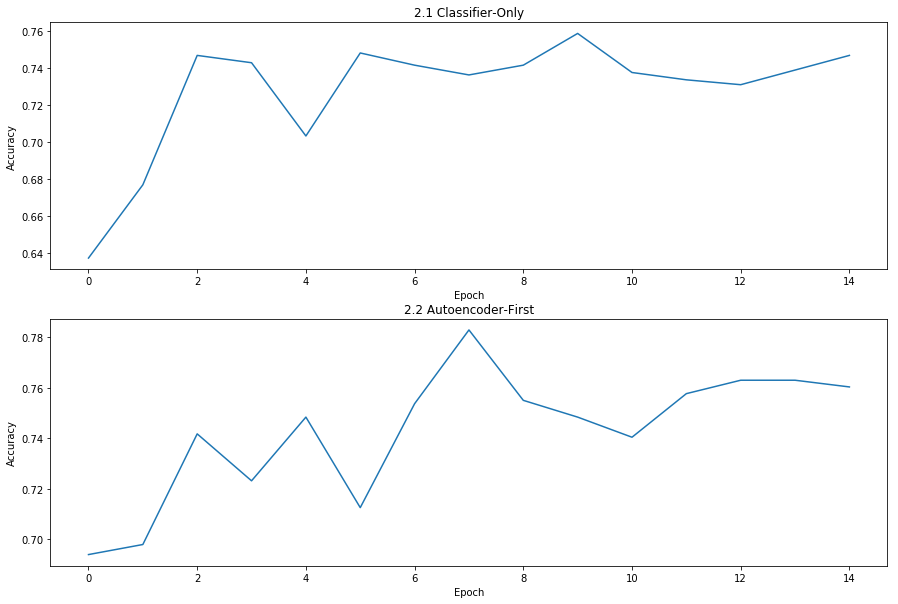

In [28]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(history1.history['val_binary_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('2.1 Classifier-Only')
ax2.plot(history2.history['val_binary_accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_title('2.2 Autoencoder-First')
fig.show()

In [40]:
accuracy1 = predictor1.evaluate(X_test, y_test)[1]
accuracy2 = predictor2.evaluate(X_test, y_test)[1]
accuracy3_a = predictor3_a.evaluate(X_test, y_test)[1]
accuracy3_b = predictor3_b.evaluate(X_test, y_test)[1]
accuracy3_c = predictor3_c.evaluate(X_test, y_test)[1]

print("\n{:<25s}{:<10s}".format("Model", "Test Accuracy"))
print("{:<25s}{:<10s}".format("-------------------", "-------------"))
print("{:<25s}{:<10s}".format("Classifier-Only", str(round(accuracy1, 4))))
print("{:<25s}{:<10s}".format("Autoencoder-First", str(round(accuracy2, 4))))
print("{:<25s}{:<10s}".format("Simultaneous (5-1)", str(round(accuracy3_a, 4))))
print("{:<25s}{:<10s}".format("Simultaneous (1-1)", str(round(accuracy3_b, 4))))
print("{:<25s}{:<10s}".format("Simultaneous (1-5)", str(round(accuracy3_c, 4))))

755/755 [==============================] - 5s 7ms/step

Model                    Test Accuracy
-------------------      -------------
Classifier-Only          0.747     
Autoencoder-First        0.7603    
Simultaneous (5-1)       0.5126    
Simultaneous (1-1)       0.5126    
Simultaneous (1-5)       0.5126    


# Visual Encodings

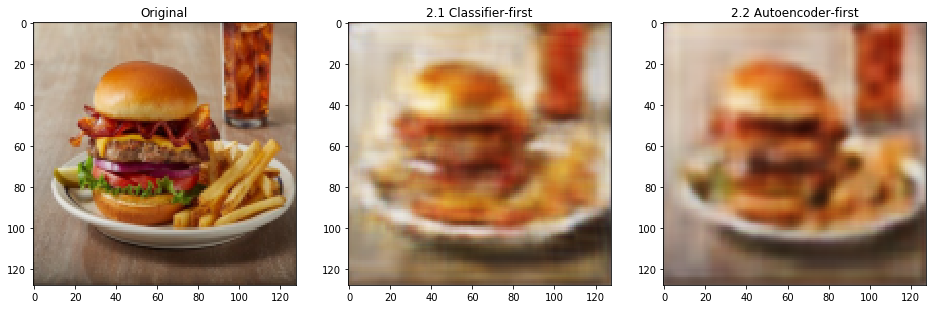

In [78]:
N = 10
fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.imshow(X_test[N])
ax2.imshow(autoencoder1.predict(X_test[N:N+1])[0])
ax3.imshow(autoencoder2.predict(X_test[N:N+1])[0])
ax1.set_title("Original")
ax2.set_title("2.1 Classifier-first")
ax3.set_title("2.2 Autoencoder-first")
fig.show()

# Variational Autoencoder

In [ ]:
def custom_loss(reconstructed, image):
    reconstruction_loss = losses.mse(reconstructed, image)
    kl_loss = K.mean(-0.5 * K.sum(1 + log_vars - K.square(means) - K.exp(log_vars), axis=-1))
    return reconstruction_loss + 0.01 * kl_loss

def sampling(args):
    means, log_vars = args
    normal = K.random_normal_variable(shape=(32,32,4), mean=0., scale=1.)
    return means + normal * K.exp(log_vars)

In [ ]:
encoder = Sequential()
encoder.add(Conv2D(64, 3, strides=1, padding='same', activation='relu'))
encoder.add(MaxPooling2D(pool_size=2))
encoder.add(Conv2D(64, 3, strides=1, padding='same', activation='relu'))
encoder.add(MaxPooling2D(pool_size=2))
encoder.add(Conv2D(32, 3, strides=1, padding='same', name='encoded', activation='relu'))
encoder.add(Conv2D(8, 3, strides=1, padding='same', activation='relu'))
encoder.add(Conv2D(5, 3, strides=1, padding='same', activation='relu'))

encoded_means = Dense(4, activation='relu')
encoded_log_vars = Dense(4, activation='relu')

decoder = Sequential()
decoder.add(Conv2D(32, 3, strides=1, padding='same'))
decoder.add(UpSampling2D(size=2))
decoder.add(Conv2D(64, 3, strides=1, padding='same'))
decoder.add(UpSampling2D(size=2))
decoder.add(Conv2D(3, 3, strides=1, padding='same'))

image = Input(shape=(128,128,3))
means = encoded_means(encoder(image))
log_vars = encoded_log_vars(encoder(image))
sampled_space = Lambda(sampling, name='sampled')([means, log_vars])
reconstruction = decoder(sampled_space)

vae5 = Model(image, reconstruction)

vae5.compile(loss=custom_loss, optimizer='rmsprop')

In [ ]:
vae5.fit(X_train, X_train, batch_size=5, epochs=20)

In [ ]:
# Sample reconstructions
idx = 224

plt.imshow(vae5.predict(X_test[idx:idx + 1])[0])
plt.show()
plt.imshow(X_test[idx])
plt.show()

In [ ]:
# Generated images
gen_sample = Input(shape=(32,32,4,))
gen_recon = decoder(gen_sample)
generator = Model(gen_sample, gen_recon)
plt.imshow(generator.predict(np.random.normal(loc=0., scale=1, size=(1,32,32,4)))[0])